In [1]:
# Instalacja wszystkich wymaganych pakietów
install.packages(c("tidyverse", "readr", "lubridate", "corrplot",
                   "VIM", "mice", "ggplot2", "gridExtra", "scales",
                   "knitr", "psych", "car", "GGally", "stringr"),
                 repos = "http://cran.us.r-project.org")

# Sprawdzenie instalacji
installed_packages <- installed.packages()[,"Package"]
required_packages <- c("tidyverse", "readr", "lubridate", "corrplot",
                      "VIM", "mice", "ggplot2", "gridExtra", "scales",
                      "knitr", "psych", "car", "GGally", "stringr")

missing_packages <- setdiff(required_packages, installed_packages)
if(length(missing_packages) > 0) {
  cat("Brakujące pakiety:", paste(missing_packages, collapse = ", "), "\n")
  cat("Próba ponownej instalacji...\n")
  install.packages(missing_packages, repos = "http://cran.us.r-project.org")
} else {
  cat("Wszystkie pakiety zainstalowane pomyślnie!\n")
}
# ROZWIĄZYWANIE PROBLEMÓW:
# Jeśli błąd "package not available":
# - Spróbuj: install.packages("nazwa_pakietu", dependencies = TRUE)
# - Lub użyj innego mirror: repos = "https://cloud.r-project.org"

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ucminf’, ‘rbibutils’, ‘zoo’, ‘iterators’, ‘ordinal’, ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘DEoptimR’, ‘lmtest’, ‘proxy’, ‘RcppEigen’, ‘foreach’, ‘shape’, ‘pan’, ‘jomo’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘patchwork’, ‘colorspace’, ‘robustbase’, ‘sp’, ‘vcd’, ‘e1071’, ‘laeken’, ‘ranger’, ‘glmnet’, ‘mitml’, ‘mnormt’, ‘GPArotation’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘ggstats’, ‘plyr’




Wszystkie pakiety zainstalowane pomyślnie!


In [2]:
# UWAGA: Jeśli pojawi się błąd przy ładowaniu bibliotek,
# upewnij się, że wszystkie pakiety zostały zainstalowane w komórce 1

# Załadowanie bibliotek
suppressPackageStartupMessages({
  library(tidyverse)
  library(readr)
  library(lubridate)
  library(corrplot)
  library(VIM)
  library(mice)
  library(ggplot2)
  library(gridExtra)
  library(scales)
  library(knitr)
  library(psych)  # WAŻNE: dla funkcji skew() i kurtosi()
  library(car)
  library(GGally)
  library(stringr)
})

# Ustawienia globalne
options(scipen = 999)  # Wyłącz notację naukową
options(digits = 3)    # Liczba cyfr znaczących
theme_set(theme_minimal())  # Domyślny styl wykresów

cat("Biblioteki załadowane!\n")
cat("Analiza danych Airbnb - Winnipeg\n")
cat("Data:", format(Sys.Date(), "%d-%m-%Y"), "\n")
cat("\nWSKAZÓWKA: Uruchamiaj komórki po kolei używając Shift+Enter\n")

Biblioteki załadowane!
Analiza danych Airbnb - Winnipeg
Data: 03-06-2025 

WSKAZÓWKA: Uruchamiaj komórki po kolei używając Shift+Enter


In [22]:
cat("\n=== 1. POPRAWNE ZAŁADOWANIE DANYCH ===\n")

# URL do danych Winnipeg
url <- "https://data.insideairbnb.com/australia/wa/western-australia/2025-03-18/data/listings.csv.gz"

# Załadowanie danych
cat("Pobieranie danych z:", url, "\n")
start_time <- Sys.time()

df <- read_csv(
  url,
  col_types = cols(),
  locale = locale(encoding = "UTF-8"),
  na = c("", "NA", "N/A", "null"),
  show_col_types = FALSE
)

load_time <- difftime(Sys.time(), start_time, units = "secs")
cat("\nDane załadowane pomyślnie!\n")
cat("Czas ładowania:", round(load_time, 2), "sekund\n")
cat("Liczba wierszy:", nrow(df), "\n")
cat("Liczba kolumn:", ncol(df), "\n")


=== 1. POPRAWNE ZAŁADOWANIE DANYCH ===
Pobieranie danych z: https://data.insideairbnb.com/australia/wa/western-australia/2025-03-18/data/listings.csv.gz 

Dane załadowane pomyślnie!
Czas ładowania: 2.11 sekund
Liczba wierszy: 12232 
Liczba kolumn: 79 


In [23]:
cat("\n=== 2. ROZMIAR ZBIORU I CZASOCHŁONNOŚĆ ===\n")

# Informacje o zbiorze
n_rows <- nrow(df)
n_cols <- ncol(df)
memory_size <- object.size(df)

cat("Liczba obserwacji:", format(n_rows, big.mark = ","), "\n")
cat("Liczba zmiennych:", n_cols, "\n")
cat("Rozmiar w pamięci:", format(memory_size, units = "MB"), "\n")

# Oszacowanie czasochłonności
cat("\nOszacowanie czasochłonności operacji:\n")

sample_size <- min(100, n_rows)
sample_df <- df[1:sample_size, ]

# Test operacji
operations <- list(
  "Statystyki opisowe" = function(x) summary(x),
  "Macierz korelacji" = function(x) cor(select_if(x, is.numeric), use = "complete.obs"),
  "Grupowanie" = function(x) x %>% group_by(room_type) %>% summarise(n = n()),
  "Wizualizacja" = function(x) ggplot(x, aes(x = price)) + geom_histogram()
)

time_estimates <- data.frame()
for(op_name in names(operations)) {
  op_time <- system.time({
    suppressWarnings(suppressMessages(operations[[op_name]](sample_df)))
  })[3]

  estimated_full_time <- op_time * n_rows / sample_size
  time_estimates <- rbind(time_estimates,
                         data.frame(
                           Operacja = op_name,
                           Czas_probki_ms = round(op_time * 1000, 1),  # w milisekundach
                           Szacowany_czas_pelny_s = round(estimated_full_time, 3)
                         ))
}

print(time_estimates)


=== 2. ROZMIAR ZBIORU I CZASOCHŁONNOŚĆ ===
Liczba obserwacji: 12,232 
Liczba zmiennych: 79 
Rozmiar w pamięci: 32.2 Mb 

Oszacowanie czasochłonności operacji:
                   Operacja Czas_probki_ms Szacowany_czas_pelny_s
elapsed  Statystyki opisowe             24                  2.936
elapsed1  Macierz korelacji             31                  3.792
elapsed2         Grupowanie              8                  0.979
elapsed3       Wizualizacja              7                  0.856


In [24]:
cat("\n=== 3. PRÓBKA SUROWYCH DANYCH ===\n")

# Lista wszystkich kolumn
cat("\nWszystkie kolumny (", n_cols, "):\n", sep = "")
print(names(df))

# Kluczowe kolumny
key_columns <- c("id", "name", "price", "room_type", "property_type",
                "accommodates", "bedrooms", "beds", "bathrooms_text",
                "neighbourhood_cleansed", "review_scores_rating",
                "host_is_superhost", "minimum_nights")

available_key_cols <- key_columns[key_columns %in% names(df)]

cat("\nPierwsze 5 wierszy (wybrane kolumny):\n")
print(head(df[, available_key_cols], 5))

cat("\nLosowe 5 wierszy:\n")
set.seed(123)
print(df[sample(n_rows, 5), available_key_cols])

cat("\nOstatnie 5 wierszy:\n")
print(tail(df[, available_key_cols], 5))



=== 3. PRÓBKA SUROWYCH DANYCH ===

Wszystkie kolumny (79):
 [1] "id"                                          
 [2] "listing_url"                                 
 [3] "scrape_id"                                   
 [4] "last_scraped"                                
 [5] "source"                                      
 [6] "name"                                        
 [7] "description"                                 
 [8] "neighborhood_overview"                       
 [9] "picture_url"                                 
[10] "host_id"                                     
[11] "host_url"                                    
[12] "host_name"                                   
[13] "host_since"                                  
[14] "host_location"                               
[15] "host_about"                                  
[16] "host_response_time"                          
[17] "host_response_rate"                          
[18] "host_acceptance_rate"                        
[19]

In [25]:
cat("\n=== 4. WERYFIKACJA TYPÓW ZMIENNYCH ===\n")

# Analiza typów przed konwersją
cat("Typy zmiennych przed konwersją:\n")
types_before <- df %>%
  summarise_all(class) %>%
  gather(key = "Kolumna", value = "Typ") %>%
  count(Typ)
print(types_before)

# Konwersja typów
cat("\nKonwersja typów zmiennych...\n")

# Zachowaj kopię oryginalnych danych przed konwersją
df_before_conversion <- df

df <- df %>%
  mutate(
    # NUMERYCZNE - konwersja cen
    price = as.numeric(gsub("[$,]", "", price)),

    # DATY
    host_since = as.Date(host_since),
    first_review = as.Date(first_review),
    last_review = as.Date(last_review),
    last_scraped = as.Date(last_scraped),

    # NUMERYCZNE - procenty
    host_response_rate = as.numeric(gsub("%", "", host_response_rate)) / 100,
    host_acceptance_rate = as.numeric(gsub("%", "", host_acceptance_rate)) / 100,

    # LOGICZNE (t/f -> TRUE/FALSE)
    host_is_superhost = (host_is_superhost == "t"),
    host_has_profile_pic = (host_has_profile_pic == "t"),
    host_identity_verified = (host_identity_verified == "t"),
    has_availability = (has_availability == "t"),
    instant_bookable = (instant_bookable == "t"),

    # KATEGORYCZNE NOMINALNE
    room_type = as.factor(room_type),
    property_type = as.factor(property_type),
    neighbourhood_cleansed = as.factor(neighbourhood_cleansed),

    # KATEGORYCZNE PORZĄDKOWE
    host_response_time = factor(host_response_time,
                               levels = c("within an hour", "within a few hours",
                                        "within a day", "a few days or more"),
                               ordered = TRUE),

    # NUMERYCZNE - wyodrębnienie z tekstu
    # Sprawdź czy jest bathrooms_text, jeśli nie - użyj bathrooms
    bathrooms_numeric = if("bathrooms_text" %in% names(df)) {
      as.numeric(str_extract(bathrooms_text, "\\d+\\.?\\d*"))
    } else if("bathrooms" %in% names(df)) {
      bathrooms
    } else {
      NA
    }
  )

# Dla kompatybilności, jeśli jest kolumna bathrooms (numeryczna), użyj jej
if("bathrooms" %in% names(df_before_conversion) && is.numeric(df_before_conversion$bathrooms)) {
  df$bathrooms_numeric <- df_before_conversion$bathrooms
}

cat("Konwersja zakończona!\n")

# Typy po konwersji
types_after <- df %>%
  summarise_all(function(x) class(x)[1]) %>%
  gather(key = "Kolumna", value = "Typ") %>%
  count(Typ)
print(types_after)


=== 4. WERYFIKACJA TYPÓW ZMIENNYCH ===
Typy zmiennych przed konwersją:
# A tibble: 4 × 2
  Typ           n
  <chr>     <int>
1 Date          5
2 character    25
3 logical       7
4 numeric      42

Konwersja typów zmiennych...
Konwersja zakończona!
# A tibble: 6 × 2
  Typ           n
  <chr>     <int>
1 Date          5
2 character    18
3 factor        3
4 logical       7
5 numeric      46
6 ordered       1


In [26]:
cat("\n=== 5. PODSUMOWANIE ZMIENNYCH ===\n")

# A. ZMIENNE NUMERYCZNE - JEDNA TABELKA
cat("\n--- PODSUMOWANIE ZMIENNYCH NUMERYCZNYCH (JEDNA TABELKA) ---\n")

# UWAGA: Ta sekcja tworzy jedną zbiorczą tabelę ze statystykami dla wszystkich
# zmiennych numerycznych zgodnie z wymaganiami projektu (punkt 5)

# Wybór zmiennych numerycznych
numeric_vars <- c("price", "accommodates", "bedrooms", "beds", "bathrooms_numeric",
                 "minimum_nights", "maximum_nights", "number_of_reviews",
                 "reviews_per_month", "availability_365", "review_scores_rating")

# Filtruj tylko istniejące zmienne
numeric_vars <- numeric_vars[numeric_vars %in% names(df)]

cat("Znalezione zmienne numeryczne:", length(numeric_vars), "\n")
cat("Nazwy:", paste(numeric_vars, collapse = ", "), "\n\n")

# Funkcja do obliczania wszystkich statystyk
# Zwraca wektor nazwany z 8 statystykami
calc_all_stats <- function(x) {
  if(!is.numeric(x)) {
    return(c(Min = NA, Max = NA, Srednia = NA, Mediana = NA,
             Q1 = NA, Q3 = NA, SD = NA, Braki = NA))
  }

  stats <- c(
    Min = min(x, na.rm = TRUE),
    Max = max(x, na.rm = TRUE),
    Srednia = mean(x, na.rm = TRUE),
    Mediana = median(x, na.rm = TRUE),
    Q1 = quantile(x, 0.25, na.rm = TRUE),
    Q3 = quantile(x, 0.75, na.rm = TRUE),
    SD = sd(x, na.rm = TRUE),
    Braki = sum(is.na(x))
  )

  # Upewnij się, że nazwy są zachowane
  names(stats) <- c("Min", "Max", "Srednia", "Mediana", "Q1", "Q3", "SD", "Braki")

  return(stats)
}

# Utworzenie jednej tabelki
numeric_data <- df[, numeric_vars, drop = FALSE]

# Oblicz statystyki dla każdej kolumny
stats_list <- lapply(numeric_data, calc_all_stats)

# Konwertuj do data.frame
numeric_summary <- do.call(rbind, stats_list)
numeric_summary <- as.data.frame(numeric_summary)

# Dodaj nazwy zmiennych jako pierwszą kolumnę
numeric_summary <- data.frame(
  Zmienna = rownames(numeric_summary),
  numeric_summary,
  stringsAsFactors = FALSE
)

# Debug - sprawdź strukturę
cat("Struktura numeric_summary:\n")
str(numeric_summary)
cat("\nNazwy kolumn:", names(numeric_summary), "\n\n")

# Zaokrąglij wartości numeryczne (oprócz Zmienna i Braki)
for(col in names(numeric_summary)) {
  if(col != "Zmienna" && col != "Braki") {
    if(is.numeric(numeric_summary[[col]])) {
      numeric_summary[[col]] <- round(numeric_summary[[col]], 2)
    }
  }
}

# Upewnij się, że Braki jest liczbą całkowitą
if("Braki" %in% names(numeric_summary)) {
  numeric_summary$Braki <- as.integer(numeric_summary$Braki)
}

# Resetowanie nazw wierszy
rownames(numeric_summary) <- NULL

cat("\nTABELKA PODSUMOWANIA ZMIENNYCH NUMERYCZNYCH:\n")
print(numeric_summary)

# Dodatkowe informacje o zmiennych numerycznych
cat("\nDodatkowe informacje:\n")
cat("- Liczba analizowanych zmiennych numerycznych:", length(numeric_vars), "\n")
cat("- Zmienne z największą liczbą braków:\n")

if("Braki" %in% names(numeric_summary) && nrow(numeric_summary) >= 3) {
  top_missing <- numeric_summary[order(numeric_summary$Braki, decreasing = TRUE), ][1:3, c("Zmienna", "Braki")]
  print(top_missing, row.names = FALSE)
}


=== 5. PODSUMOWANIE ZMIENNYCH ===

--- PODSUMOWANIE ZMIENNYCH NUMERYCZNYCH (JEDNA TABELKA) ---
Znalezione zmienne numeryczne: 11 
Nazwy: price, accommodates, bedrooms, beds, bathrooms_numeric, minimum_nights, maximum_nights, number_of_reviews, reviews_per_month, availability_365, review_scores_rating 

Struktura numeric_summary:
'data.frame':	11 obs. of  9 variables:
 $ Zmienna: chr  "price" "accommodates" "bedrooms" "beds" ...
 $ Min    : num  26 1 0 0 0 1 1 0 0.01 0 ...
 $ Max    : num  10000 16 12 53 10 ...
 $ Srednia: num  280.77 4.74 2.29 2.99 1.49 ...
 $ Mediana: num  225 4 2 3 1 2 365 25 1.27 226 ...
 $ Q1     : num  154 2 1 1 1 2 60 7 0.59 94 ...
 $ Q3     : num  324 6 3 4 2 ...
 $ SD     : num  308.743 2.767 1.285 2.128 0.714 ...
 $ Braki  : num  1650 0 216 1651 1651 ...

Nazwy kolumn: Zmienna Min Max Srednia Mediana Q1 Q3 SD Braki 


TABELKA PODSUMOWANIA ZMIENNYCH NUMERYCZNYCH:
                Zmienna   Min     Max Srednia Mediana     Q1      Q3     SD
1                 pric

In [27]:
cat("\n--- ANALIZA ZMIENNYCH KATEGORYCZNYCH ---\n")

categorical_vars <- c("room_type", "property_type", "neighbourhood_cleansed",
                     "host_response_time", "host_is_superhost", "instant_bookable")

categorical_summary <- data.frame()

for(var in categorical_vars) {
  if(var %in% names(df)) {
    freq_table <- table(df[[var]], useNA = "ifany")

    # Sprawdź czy zmienna ma więcej niż jedną kategorię
    n_unique <- length(unique(na.omit(df[[var]])))

    cat_stats <- data.frame(
      Zmienna = var,
      Liczba_kategorii = n_unique,
      Najczestsza_wartosc = names(which.max(freq_table)),
      Czestosc_najczestszej = max(freq_table),
      Procent_najczestszej = round(max(freq_table) / sum(freq_table) * 100, 2),
      Liczba_unikalnych = length(unique(df[[var]])),
      Liczba_brakow = sum(is.na(df[[var]])),
      stringsAsFactors = FALSE
    )

    categorical_summary <- rbind(categorical_summary, cat_stats)

    cat(sprintf("\n%s:\n", var))
    cat(sprintf("  Liczba kategorii: %d\n", n_unique))

    if(n_unique == 1) {
      cat(sprintf("  UWAGA: Tylko jedna kategoria - %s (100%%)\n",
                  cat_stats$Najczestsza_wartosc))
    } else {
      cat(sprintf("  Najczęstsza: %s (%.1f%%)\n",
                  cat_stats$Najczestsza_wartosc,
                  cat_stats$Procent_najczestszej))
    }
  }
}

cat("\nPODSUMOWANIE ZMIENNYCH KATEGORYCZNYCH:\n")
print(categorical_summary, row.names = FALSE)


--- ANALIZA ZMIENNYCH KATEGORYCZNYCH ---

room_type:
  Liczba kategorii: 4
  Najczęstsza: Entire home/apt (83.0%)

property_type:
  Liczba kategorii: 75
  Najczęstsza: Entire home (39.0%)

neighbourhood_cleansed:
  Liczba kategorii: 110
  Najczęstsza: BUSSELTON (15.0%)

host_response_time:
  Liczba kategorii: 4
  Najczęstsza: within an hour (76.5%)

host_is_superhost:
  Liczba kategorii: 1
  UWAGA: Tylko jedna kategoria - FALSE (100%)

instant_bookable:
  Liczba kategorii: 1
  UWAGA: Tylko jedna kategoria - FALSE (100%)

PODSUMOWANIE ZMIENNYCH KATEGORYCZNYCH:
                Zmienna Liczba_kategorii Najczestsza_wartosc
              room_type                4     Entire home/apt
          property_type               75         Entire home
 neighbourhood_cleansed              110           BUSSELTON
     host_response_time                4      within an hour
      host_is_superhost                1               FALSE
       instant_bookable                1               FALSE
 Czest


=== 6. ANALIZA BRAKÓW DANYCH ===
PODSUMOWANIE BRAKÓW DANYCH:
- Zmienne bez braków: 41 
- Zmienne z brakami: 39 
- Zmienne z brakami >50%: 3 
- Zmienne z brakami 20-50%: 3 

ZMIENNE Z NAJWIĘKSZYMI BRAKAMI (>10%):
# A tibble: 12 × 3
   Zmienna                      Liczba_brakow Procent_brakow
   <chr>                                <int>          <dbl>
 1 neighbourhood_group_cleansed         12232          100  
 2 calendar_updated                     12232          100  
 3 host_neighbourhood                   12203           99.8
 4 neighborhood_overview                 6002           49.1
 5 neighbourhood                         6002           49.1
 6 host_about                            5399           44.1
 7 host_location                         2382           19.5
 8 bathrooms                             1651           13.5
 9 beds                                  1651           13.5
10 bathrooms_numeric                     1651           13.5
11 price                            

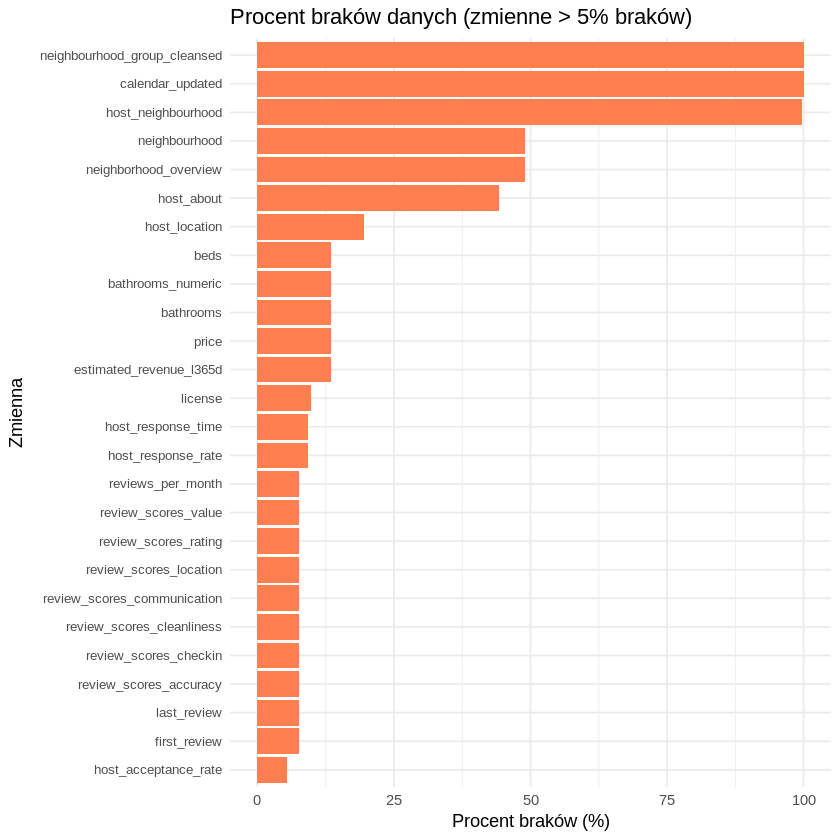

In [28]:
cat("\n=== 6. ANALIZA BRAKÓW DANYCH ===\n")

# Obliczenie braków dla wszystkich zmiennych
missing_analysis <- df %>%
  summarise_all(~sum(is.na(.))) %>%
  gather(key = "Zmienna", value = "Liczba_brakow") %>%
  mutate(
    Procent_brakow = round(Liczba_brakow / n_rows * 100, 2)
  ) %>%
  arrange(desc(Procent_brakow))

# Podsumowanie braków
cat("PODSUMOWANIE BRAKÓW DANYCH:\n")
cat("- Zmienne bez braków:", sum(missing_analysis$Liczba_brakow == 0), "\n")
cat("- Zmienne z brakami:", sum(missing_analysis$Liczba_brakow > 0), "\n")
cat("- Zmienne z brakami >50%:", sum(missing_analysis$Procent_brakow > 50), "\n")
cat("- Zmienne z brakami 20-50%:", sum(missing_analysis$Procent_brakow >= 20 &
                                       missing_analysis$Procent_brakow < 50), "\n")

# Zmienne z największymi brakami
cat("\nZMIENNE Z NAJWIĘKSZYMI BRAKAMI (>10%):\n")
high_missing <- missing_analysis %>% filter(Procent_brakow > 10)
print(head(high_missing, 15), row.names = FALSE)

# Wykres braków
ggplot(missing_analysis %>% filter(Procent_brakow > 5),
       aes(x = reorder(Zmienna, Procent_brakow), y = Procent_brakow)) +
  geom_bar(stat = "identity", fill = "coral") +
  coord_flip() +
  labs(title = "Procent braków danych (zmienne > 5% braków)",
       x = "Zmienna", y = "Procent braków (%)") +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 8))


=== 7. WIZUALIZACJA ROZKŁADÓW ===


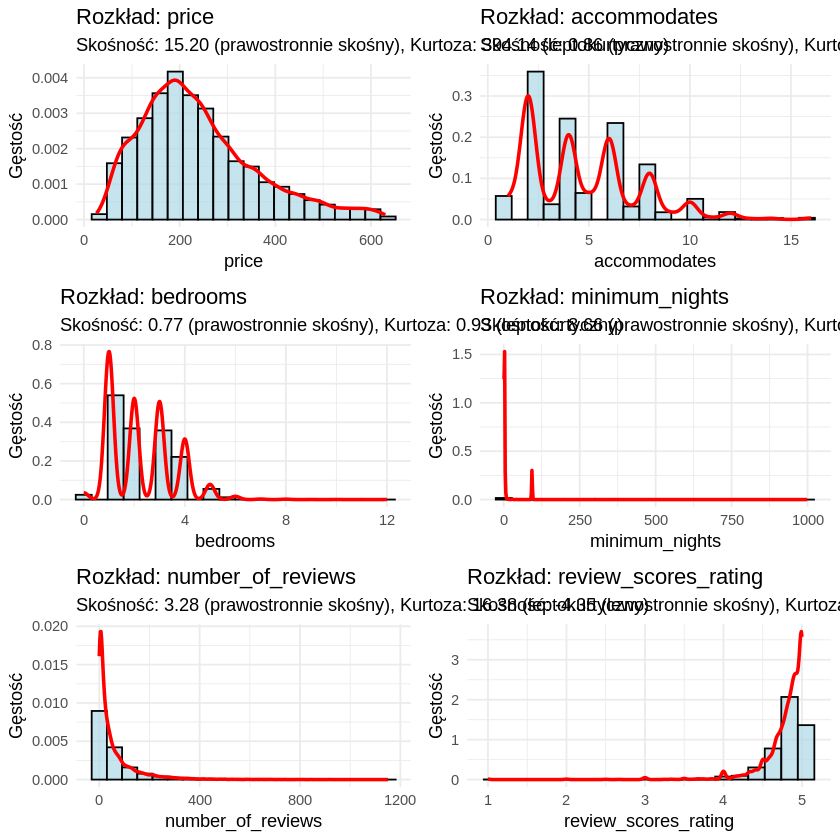

In [29]:
cat("\n=== 7. WIZUALIZACJA ROZKŁADÓW ===\n")

# UWAGA: Używamy psych::kurtosi() zamiast kurtosis() aby uniknąć błędu
# "kurtosis is not an exported object from namespace:psych"

# Funkcja do analizy rozkładu
analyze_distribution <- function(data, var_name, var_data) {
  var_clean <- var_data[!is.na(var_data)]

  # Użyj psych:: dla kurtosis i skew
  skewness <- psych::skew(var_clean)
  kurt <- psych::kurtosi(var_clean)

  skew_interp <- ifelse(abs(skewness) < 0.5, "symetryczny",
                       ifelse(skewness < 0, "lewostronnie skośny",
                             "prawostronnie skośny"))

  kurt_interp <- ifelse(abs(kurt) < 0.5, "mezokurtyczny",
                       ifelse(kurt < 0, "platykurtyczny", "leptokurtyczny"))

  list(
    name = var_name,
    skewness = skewness,
    kurtosis = kurt,
    skew_interpretation = skew_interp,
    kurt_interpretation = kurt_interp
  )
}

# Kluczowe zmienne do wizualizacji
vars_to_plot <- c("price", "accommodates", "bedrooms", "minimum_nights",
                 "number_of_reviews", "review_scores_rating")

distribution_stats <- list()
plot_list <- list()

# Sprawdź które zmienne istnieją i są numeryczne
available_vars <- c()
for(var in vars_to_plot) {
  if(var %in% names(df) && is.numeric(df[[var]])) {
    available_vars <- c(available_vars, var)
  }
}

if(length(available_vars) == 0) {
  cat("Brak numerycznych zmiennych do analizy rozkładów.\n")
} else {
  for(var in available_vars) {
    # Analiza rozkładu
    dist_stats <- analyze_distribution(df, var, df[[var]])
    distribution_stats[[var]] <- dist_stats

    # Przygotuj dane
    plot_data <- df %>% filter(!is.na(!!sym(var)))

    # Ograniczenie dla lepszej wizualizacji
    if(var == "price") {
      plot_data <- plot_data %>% filter(price <= quantile(price, 0.95))
    }

    # Histogram z krzywą gęstości
    p <- ggplot(plot_data, aes_string(x = var)) +
      geom_histogram(aes(y = after_stat(density)), bins = 20,
                    fill = "lightblue", color = "black", alpha = 0.7) +
      geom_density(color = "red", size = 1) +
      labs(title = sprintf("Rozkład: %s", var),
           subtitle = sprintf("Skośność: %.2f (%s), Kurtoza: %.2f (%s)",
                            dist_stats$skewness, dist_stats$skew_interpretation,
                            dist_stats$kurtosis, dist_stats$kurt_interpretation),
           x = var, y = "Gęstość") +
      theme_minimal()

    plot_list[[var]] <- p
  }

  # Wyświetl wykresy
  if(length(plot_list) > 0) {
    grid.arrange(grobs = plot_list[1:min(6, length(plot_list))],
                ncol = 2, nrow = 3)
  }
}


CHARAKTERYSTYKI ROZKŁADÓW:
              Zmienna Skosnosc Interpretacja_skosnosci Kurtoza
                price   15.199    prawostronnie skośny 394.139
         accommodates    0.859    prawostronnie skośny   0.584
             bedrooms    0.767    prawostronnie skośny   0.929
       minimum_nights    8.658    prawostronnie skośny 170.546
    number_of_reviews    3.285    prawostronnie skośny  16.379
 review_scores_rating   -4.352     lewostronnie skośny  34.760
 Interpretacja_kurtozy
        leptokurtyczny
        leptokurtyczny
        leptokurtyczny
        leptokurtyczny
        leptokurtyczny
        leptokurtyczny

WIZUALIZACJA ZMIENNYCH KATEGORYCZNYCH:


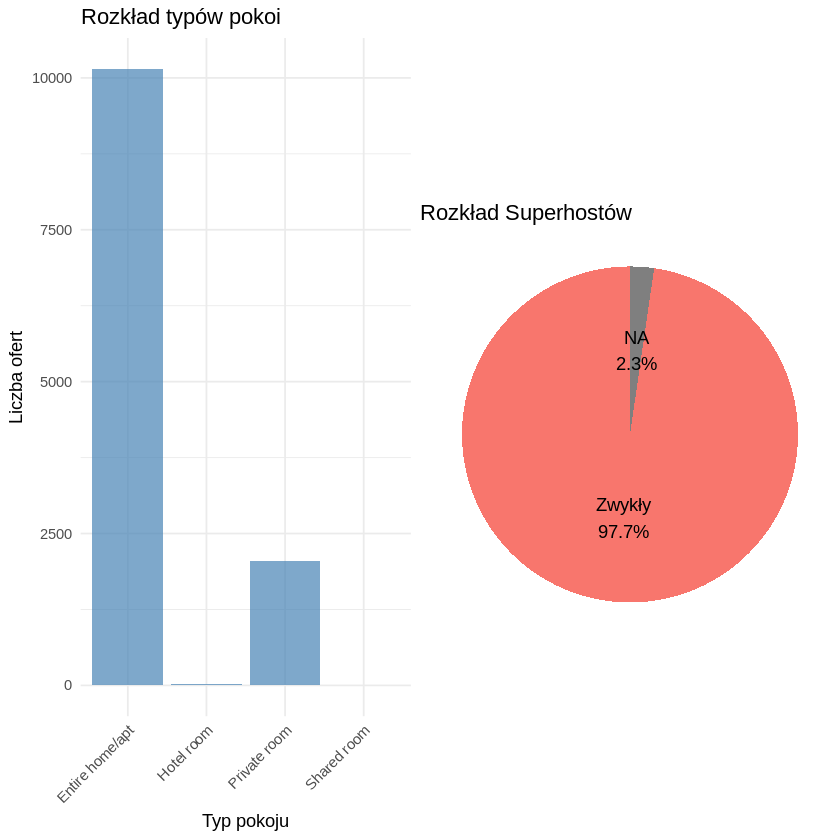

In [30]:
# Podsumowanie charakterystyk rozkładów
cat("\nCHARAKTERYSTYKI ROZKŁADÓW:\n")
if(length(distribution_stats) > 0) {
  dist_summary <- do.call(rbind, lapply(distribution_stats, function(x) {
    data.frame(
      Zmienna = x$name,
      Skosnosc = round(x$skewness, 3),
      Interpretacja_skosnosci = x$skew_interpretation,
      Kurtoza = round(x$kurtosis, 3),
      Interpretacja_kurtozy = x$kurt_interpretation
    )
  }))
  print(dist_summary, row.names = FALSE)
} else {
  cat("Brak numerycznych zmiennych do analizy rozkładów.\n")
}

# Wizualizacja zmiennych kategorycznych
cat("\nWIZUALIZACJA ZMIENNYCH KATEGORYCZNYCH:\n")

# Wykres słupkowy dla room_type
p_room <- ggplot(df, aes(x = room_type)) +
  geom_bar(fill = "steelblue", alpha = 0.7) +
  labs(title = "Rozkład typów pokoi", x = "Typ pokoju", y = "Liczba ofert") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Wykres dla superhostów
superhost_data <- df %>%
  count(host_is_superhost) %>%
  mutate(percent = n / sum(n) * 100,
         label = paste0(ifelse(host_is_superhost, "Superhost", "Zwykły"),
                       "\n", round(percent, 1), "%"))

p_superhost <- ggplot(superhost_data, aes(x = "", y = n, fill = host_is_superhost)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  geom_text(aes(label = label), position = position_stack(vjust = 0.5)) +
  labs(title = "Rozkład Superhostów") +
  theme_void() +
  theme(legend.position = "none")

grid.arrange(p_room, p_superhost, ncol = 2)


In [31]:
cat("\n=== 8. CZYSZCZENIE DANYCH ===\n")

# Kopia oryginalnych danych
df_before_cleaning <- df
n_before <- nrow(df)

# A. USUNIĘCIE WIERSZY/KOLUMN Z DUŻĄ LICZBĄ BRAKÓW
cat("\n--- Usuwanie kolumn z >70% braków ---\n")

cols_to_remove <- missing_analysis %>%
  filter(Procent_brakow > 70) %>%
  pull(Zmienna)

if(length(cols_to_remove) > 0) {
  cat("Usuwane kolumny:", paste(cols_to_remove, collapse = ", "), "\n")
  df <- df %>% select(-all_of(cols_to_remove))
}

# Usunięcie wierszy bez ceny
df <- df %>% filter(!is.na(price))
cat(sprintf("\nUsunięto %d wierszy bez ceny\n", n_before - nrow(df)))

# B. PRZYCIĘCIE WARTOŚCI ODSTAJĄCYCH
cat("\n--- Przycięcie wartości odstających ---\n")

# Funkcja do przycięcia outlierów
trim_outliers <- function(x, lower_percentile = 0.01, upper_percentile = 0.99) {
  if(!is.numeric(x)) return(x)

  bounds <- quantile(x, c(lower_percentile, upper_percentile), na.rm = TRUE)
  x[x < bounds[1]] <- bounds[1]
  x[x > bounds[2]] <- bounds[2]
  return(x)
}

# Przycięcie dla wybranych zmiennych
outlier_vars <- c("price", "minimum_nights", "maximum_nights")

for(var in outlier_vars) {
  if(var %in% names(df)) {
    original_mean <- mean(df[[var]], na.rm = TRUE)
    df[[var]] <- trim_outliers(df[[var]])
    new_mean <- mean(df[[var]], na.rm = TRUE)
    cat(sprintf("%s: średnia przed = %.2f, po = %.2f\n",
                var, original_mean, new_mean))
  }
}


=== 8. CZYSZCZENIE DANYCH ===

--- Usuwanie kolumn z >70% braków ---
Usuwane kolumny: neighbourhood_group_cleansed, calendar_updated, host_neighbourhood 

Usunięto 1650 wierszy bez ceny

--- Przycięcie wartości odstających ---
price: średnia przed = 280.77, po = 271.46
minimum_nights: średnia przed = 9.97, po = 9.68
maximum_nights: średnia przed = 454.54, po = 454.56


In [32]:
cat("\n--- IMPUTACJA BRAKÓW DANYCH METODĄ MICE ---\n")

# Wybór zmiennych do imputacji
impute_vars <- c("bedrooms", "beds", "bathrooms_numeric",
                "review_scores_rating", "review_scores_accuracy",
                "review_scores_cleanliness", "review_scores_checkin",
                "review_scores_communication", "review_scores_location",
                "review_scores_value", "reviews_per_month")

# Dodaj predyktory
predictor_vars <- c("room_type", "accommodates", "price", "neighbourhood_cleansed")

# Wszystkie zmienne do MICE
mice_vars <- unique(c(impute_vars, predictor_vars))
mice_vars <- mice_vars[mice_vars %in% names(df)]

# Przygotuj dane do MICE
df_for_mice <- df[, mice_vars]

# Sprawdź braki przed imputacją
cat("\nBraki przed imputacją:\n")
before_missing <- colSums(is.na(df_for_mice))
print(before_missing[before_missing > 0])

# Wykonaj imputację MICE
cat("\nWykonywanie imputacji MICE (dla małego zbioru powinno być szybkie)...\n")
mice_time_start <- Sys.time()

# Konfiguracja MICE - mniej iteracji dla małego zbioru
mice_result <- mice(
  df_for_mice,
  m = 3,  # mniej imputacji dla małego zbioru
  method = 'pmm',  # predictive mean matching
  seed = 123,
  printFlag = FALSE
)

# Wybierz kompletny zbiór danych
df_mice_complete <- complete(mice_result)

mice_time_end <- Sys.time()
mice_duration <- difftime(mice_time_end, mice_time_start, units = "secs")
cat(sprintf("Czas imputacji MICE: %.1f sekund\n", mice_duration))

# Aktualizuj oryginalny zbiór
df[, names(df_mice_complete)] <- df_mice_complete

# Sprawdź braki po imputacji
cat("\nBraki po imputacji:\n")
after_missing <- colSums(is.na(df[, impute_vars]))
if(sum(after_missing) == 0) {
  cat("Wszystkie braki zostały uzupełnione!\n")
} else {
  print(after_missing[after_missing > 0])
}


--- IMPUTACJA BRAKÓW DANYCH METODĄ MICE ---

Braki przed imputacją:
                   bedrooms                        beds 
                          1                           2 
          bathrooms_numeric        review_scores_rating 
                          2                         776 
     review_scores_accuracy   review_scores_cleanliness 
                        776                         776 
      review_scores_checkin review_scores_communication 
                        776                         776 
     review_scores_location         review_scores_value 
                        776                         776 
          reviews_per_month 
                        776 

Wykonywanie imputacji MICE (dla małego zbioru powinno być szybkie)...


Warning message:
“Number of logged events: 165”


Czas imputacji MICE: 88.2 sekund

Braki po imputacji:
Wszystkie braki zostały uzupełnione!



DIAGNOSTYKA IMPUTACJI:


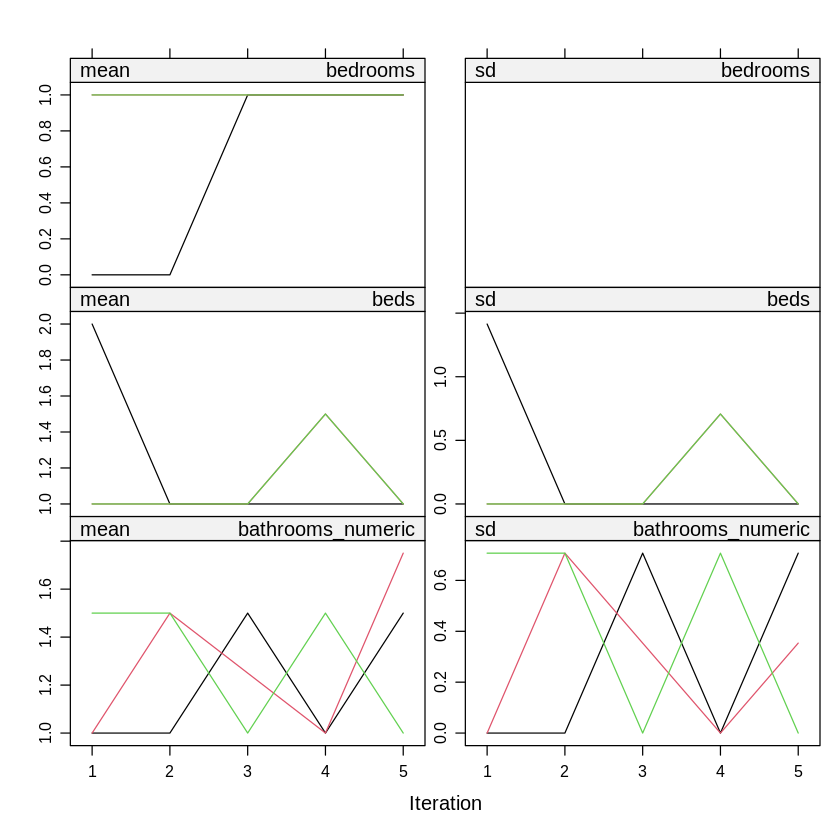

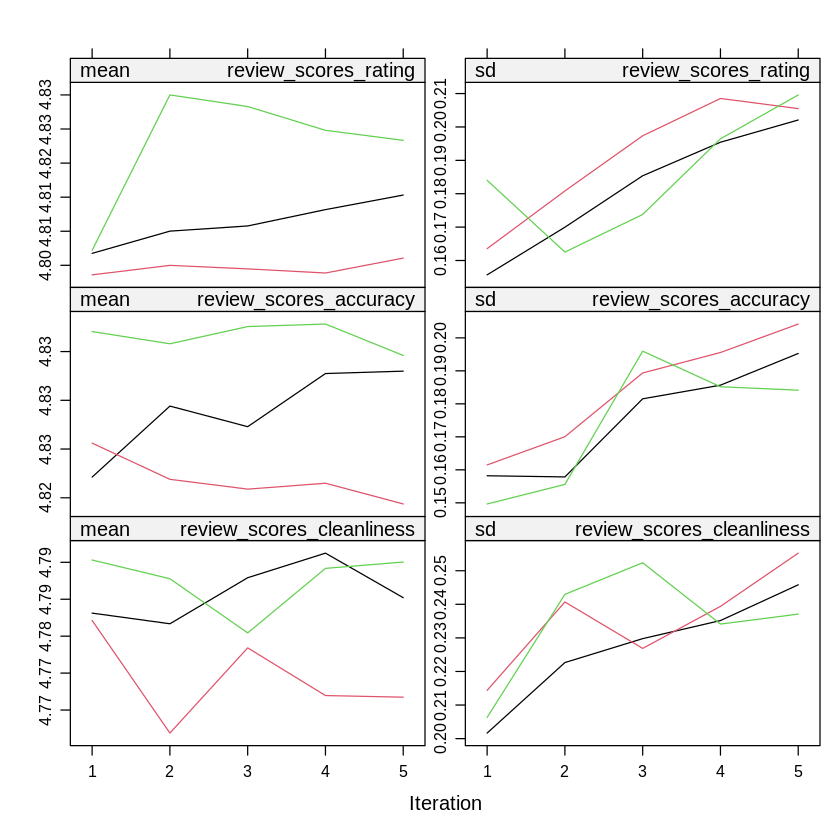

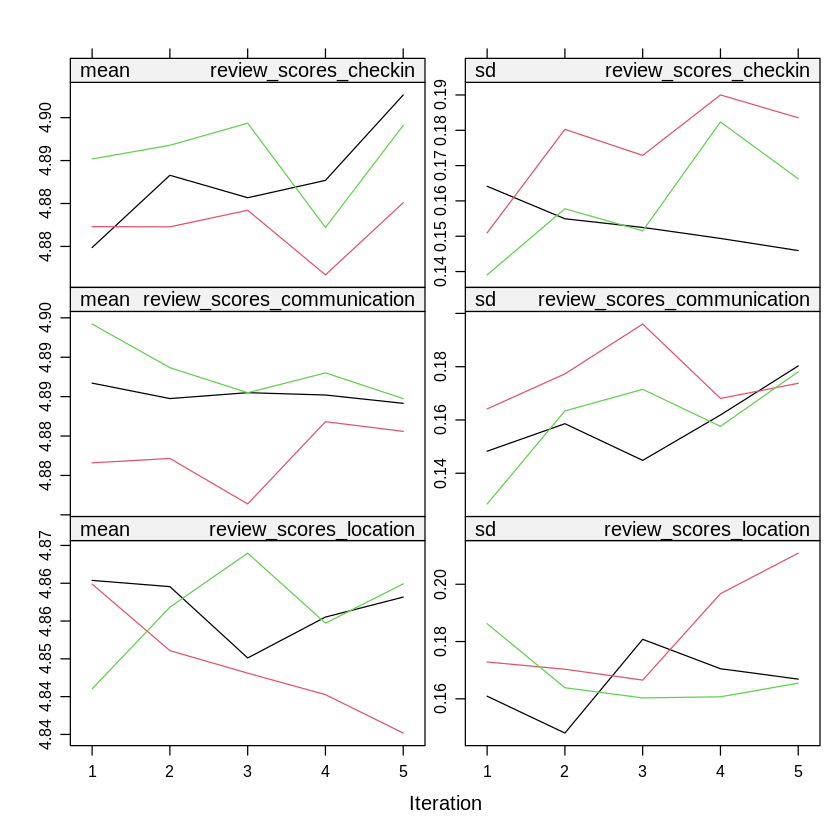

Nie można wygenerować wykresu gęstości - prawdopodobnie zbyt mało unikalnych wartości

--- NORMALIZACJA DANYCH ---
Znormalizowano 8 zmiennych (min-max i z-score)

--- PODSUMOWANIE CZYSZCZENIA DANYCH ---
Liczba obserwacji przed: 12232
Liczba obserwacji po: 10582
Usunięto: 1650 (13.5%)


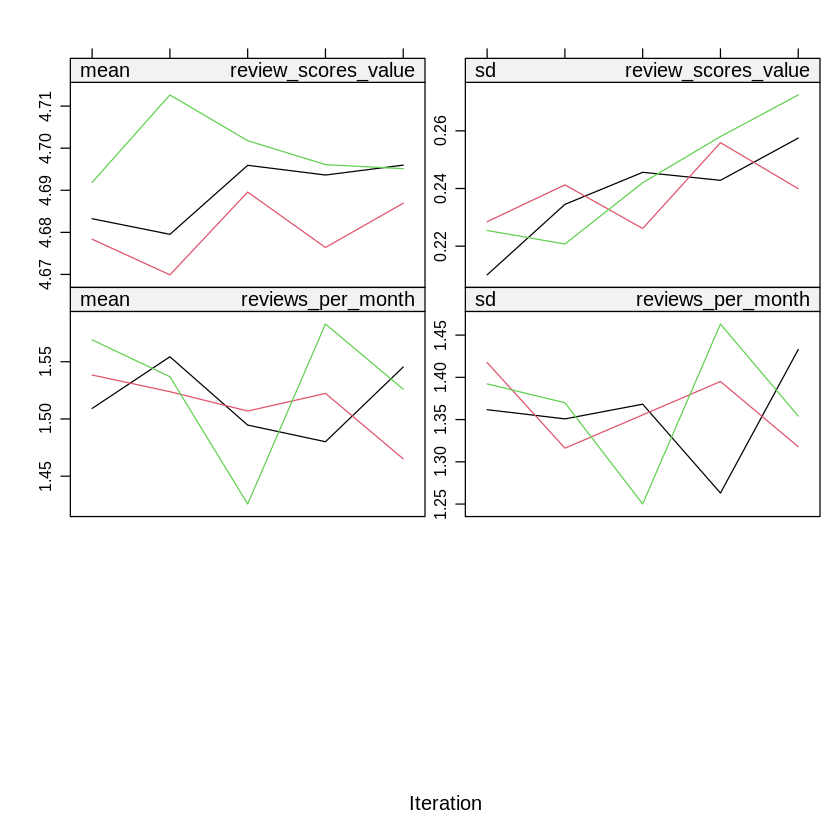

In [33]:
# Diagnostyka imputacji
cat("\nDIAGNOSTYKA IMPUTACJI:\n")

# Wykres zbieżności
tryCatch({
  plot(mice_result, layout = c(2, 3))
}, error = function(e) {
  cat("Nie można wygenerować wykresu zbieżności\n")
})

# Porównanie rozkładów przed i po imputacji - tylko jeśli są dane
tryCatch({
  densityplot(mice_result, ~bedrooms + beds + bathrooms_numeric)
}, error = function(e) {
  cat("Nie można wygenerować wykresu gęstości - prawdopodobnie zbyt mało unikalnych wartości\n")
})

# D. NORMALIZACJA DANYCH
cat("\n--- NORMALIZACJA DANYCH ---\n")

# Min-Max normalizacja
normalize_minmax <- function(x) {
  if(!is.numeric(x) || length(unique(x)) == 1) return(x)
  (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))
}

# Z-score normalizacja
normalize_zscore <- function(x) {
  if(!is.numeric(x) || sd(x, na.rm = TRUE) == 0) return(x)
  (x - mean(x, na.rm = TRUE)) / sd(x, na.rm = TRUE)
}

# Zmienne do normalizacji
norm_vars <- c("price", "accommodates", "bedrooms", "beds", "bathrooms_numeric",
              "minimum_nights", "number_of_reviews", "availability_365")

# Tworzenie znormalizowanych wersji
df_normalized <- df
for(var in norm_vars) {
  if(var %in% names(df)) {
    df_normalized[[paste0(var, "_minmax")]] <- normalize_minmax(df[[var]])
    df_normalized[[paste0(var, "_zscore")]] <- normalize_zscore(df[[var]])
  }
}

cat(sprintf("Znormalizowano %d zmiennych (min-max i z-score)\n", length(norm_vars)))

# Finalne dane
df_clean <- df_normalized

# PODSUMOWANIE CZYSZCZENIA
cat("\n--- PODSUMOWANIE CZYSZCZENIA DANYCH ---\n")
cat(sprintf("Liczba obserwacji przed: %d\n", n_before))
cat(sprintf("Liczba obserwacji po: %d\n", nrow(df_clean)))
cat(sprintf("Usunięto: %d (%.1f%%)\n",
           n_before - nrow(df_clean),
           (n_before - nrow(df_clean)) / n_before * 100))


=== 9. ANALIZA ZALEŻNOŚCI ===

--- MACIERZ KORELACJI (PEARSON I SPEARMAN) ---

Najsilniejsze korelacje z ceną:
                                  Zmienna Pearson Spearman
accommodates                 accommodates   0.593    0.672
bedrooms                         bedrooms   0.593    0.654
bathrooms_numeric       bathrooms_numeric   0.586    0.569
beds                                 beds   0.500    0.599
number_of_reviews       number_of_reviews  -0.152   -0.141
review_scores_rating review_scores_rating   0.078    0.081
availability_365         availability_365   0.070    0.065
minimum_nights             minimum_nights  -0.047    0.021


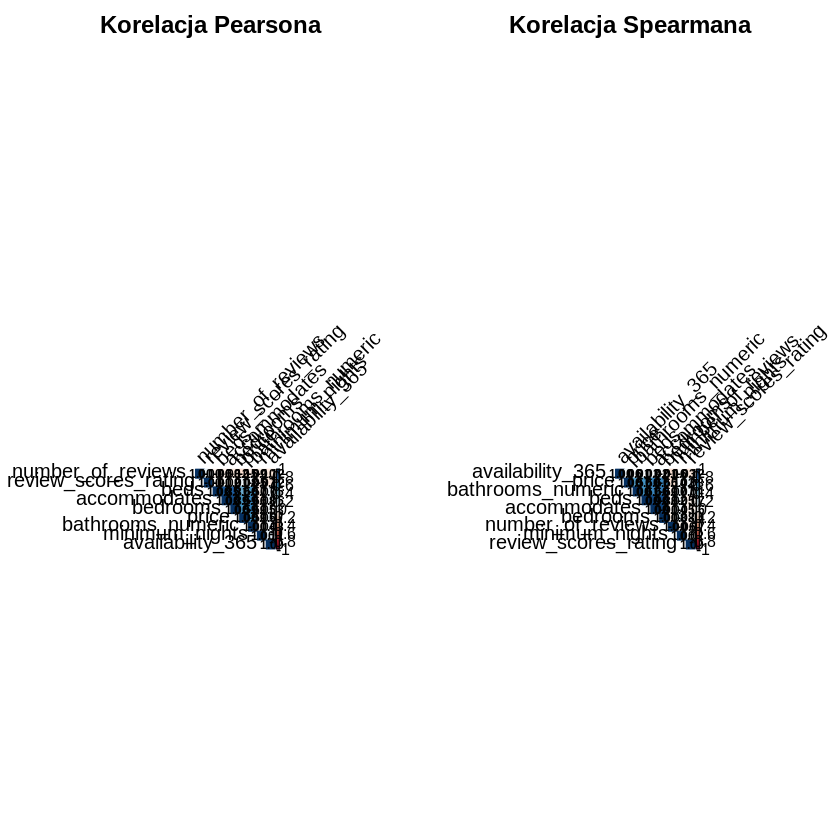

In [34]:
cat("\n=== 9. ANALIZA ZALEŻNOŚCI ===\n")
cat("\n--- MACIERZ KORELACJI (PEARSON I SPEARMAN) ---\n")

# Wybór zmiennych
cor_vars <- c("price", "accommodates", "bedrooms", "beds", "bathrooms_numeric",
             "minimum_nights", "number_of_reviews", "review_scores_rating",
             "availability_365")
cor_vars <- cor_vars[cor_vars %in% names(df_clean)]

# Dane do korelacji
cor_data <- df_clean[, cor_vars] %>% na.omit()

# Oblicz korelacje
cor_pearson <- cor(cor_data, method = "pearson")
cor_spearman <- cor(cor_data, method = "spearman")

# Wizualizacja macierzy korelacji
par(mfrow = c(1, 2), mar = c(2, 2, 3, 2))

corrplot(cor_pearson, method = "color", type = "upper",
         order = "hclust", tl.col = "black", tl.srt = 45,
         addCoef.col = "black", number.cex = 0.6,
         title = "Korelacja Pearsona", mar = c(0,0,2,0))

corrplot(cor_spearman, method = "color", type = "upper",
         order = "hclust", tl.col = "black", tl.srt = 45,
         addCoef.col = "black", number.cex = 0.6,
         title = "Korelacja Spearmana", mar = c(0,0,2,0))

par(mfrow = c(1, 1))

# Najsilniejsze korelacje
cat("\nNajsilniejsze korelacje z ceną:\n")
price_correlations <- data.frame(
  Zmienna = names(cor_pearson[,"price"]),
  Pearson = round(cor_pearson[,"price"], 3),
  Spearman = round(cor_spearman[,"price"], 3)
) %>%
  filter(Zmienna != "price") %>%
  arrange(desc(abs(Pearson)))

print(price_correlations)


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


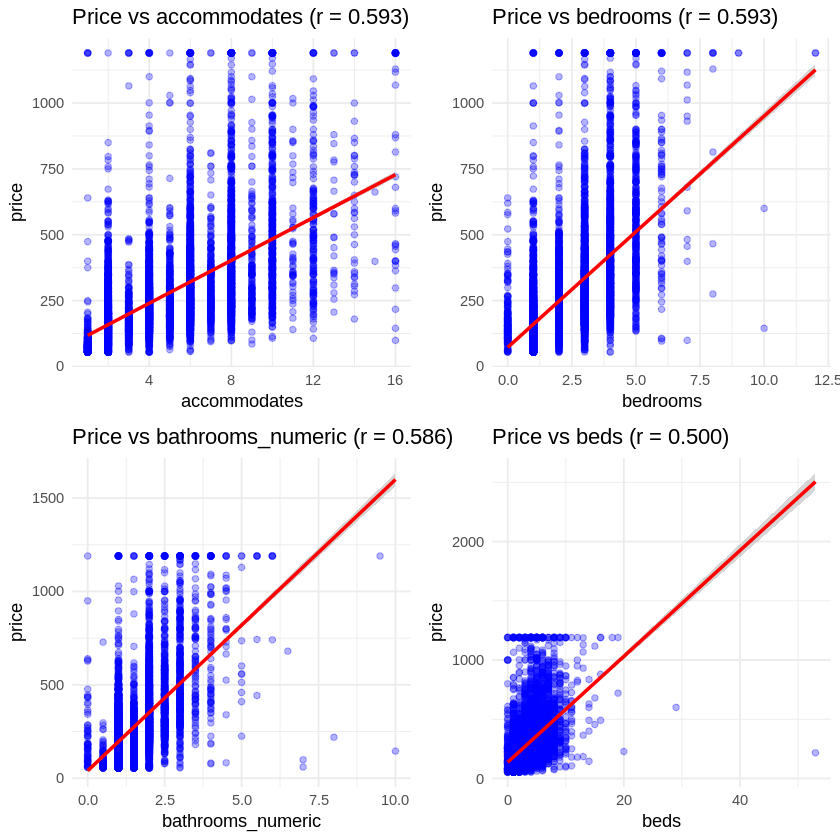

In [35]:
# Scatter plots dla najsilniejszych korelacji
top_correlations <- price_correlations$Zmienna[1:4]

scatter_plots <- list()
for(var in top_correlations) {
  p <- ggplot(df_clean, aes_string(x = var, y = "price")) +
    geom_point(alpha = 0.3, color = "blue") +
    geom_smooth(method = "lm", color = "red") +
    labs(title = sprintf("Price vs %s (r = %.3f)",
                        var, cor_pearson[var, "price"])) +
    theme_minimal()
  scatter_plots[[var]] <- p
}

grid.arrange(grobs = scatter_plots, ncol = 2)

In [36]:
cat("\n--- WSPÓŁCZYNNIK V CRAMÉRA ---\n")

# Funkcja V Craméra
cramers_v <- function(x, y) {
  # Sprawdź czy obie zmienne mają więcej niż jedną kategorię
  if(length(unique(x)) < 2 || length(unique(y)) < 2) {
    return(NA)
  }

  tbl <- table(x, y)
  chi2 <- suppressWarnings(chisq.test(tbl)$statistic)
  n <- sum(tbl)
  phi2 <- chi2 / n
  r <- nrow(tbl)
  k <- ncol(tbl)

  phi2_corrected <- max(0, phi2 - ((k-1)*(r-1))/(n-1))
  r_corrected <- r - ((r-1)^2)/(n-1)
  k_corrected <- k - ((k-1)^2)/(n-1)

  v <- sqrt(phi2_corrected / min(k_corrected-1, r_corrected-1))
  return(as.numeric(v))
}

# Pary zmiennych kategorycznych
cat_pairs <- list(
  c("room_type", "property_type"),
  c("room_type", "instant_bookable"),
  c("host_is_superhost", "instant_bookable"),
  c("room_type", "host_is_superhost")
)

# Pary zmiennych kategorycznych
cat_pairs <- list(
  c("room_type", "property_type"),
  c("room_type", "instant_bookable"),
  c("host_is_superhost", "instant_bookable"),
  c("room_type", "host_is_superhost")
)

# Sprawdź które zmienne mają więcej niż jedną kategorię
valid_cat_vars <- c()
for(var in c("room_type", "property_type", "instant_bookable", "host_is_superhost")) {
  if(var %in% names(df_clean) && length(unique(df_clean[[var]])) > 1) {
    valid_cat_vars <- c(valid_cat_vars, var)
  } else if(var %in% names(df_clean)) {
    cat(sprintf("UWAGA: %s ma tylko jedną kategorię - pomijam w analizie V Craméra\n", var))
  }
}

# Filtruj pary aby zawierały tylko zmienne z więcej niż jedną kategorią
valid_pairs <- list()
for(pair in cat_pairs) {
  if(all(pair %in% valid_cat_vars)) {
    valid_pairs <- append(valid_pairs, list(pair))
  }
}

cramers_results <- data.frame()
for(pair in valid_pairs) {
  v <- cramers_v(df_clean[[pair[1]]], df_clean[[pair[2]]])
  if(!is.na(v)) {
    cramers_results <- rbind(cramers_results,
                           data.frame(
                             Zmienna1 = pair[1],
                             Zmienna2 = pair[2],
                             V_Cramera = round(v, 3)
                           ))
  }
}

if(nrow(cramers_results) > 0) {
  print(cramers_results)
} else {
  cat("Nie można obliczyć V Craméra - większość zmiennych kategorycznych ma tylko jedną kategorię\n")
}


--- WSPÓŁCZYNNIK V CRAMÉRA ---
UWAGA: instant_bookable ma tylko jedną kategorię - pomijam w analizie V Craméra
   Zmienna1          Zmienna2 V_Cramera
1 room_type host_is_superhost       Inf



--- WSPÓŁCZYNNIK R² DLA ZMIENNYCH KATEGORYCZNYCH ---
    Zmienna_kategoryczna R2_dla_ceny
1          property_type       0.251
2 neighbourhood_cleansed       0.164
3              room_type       0.105
4      host_is_superhost       0.000
5       instant_bookable       0.000


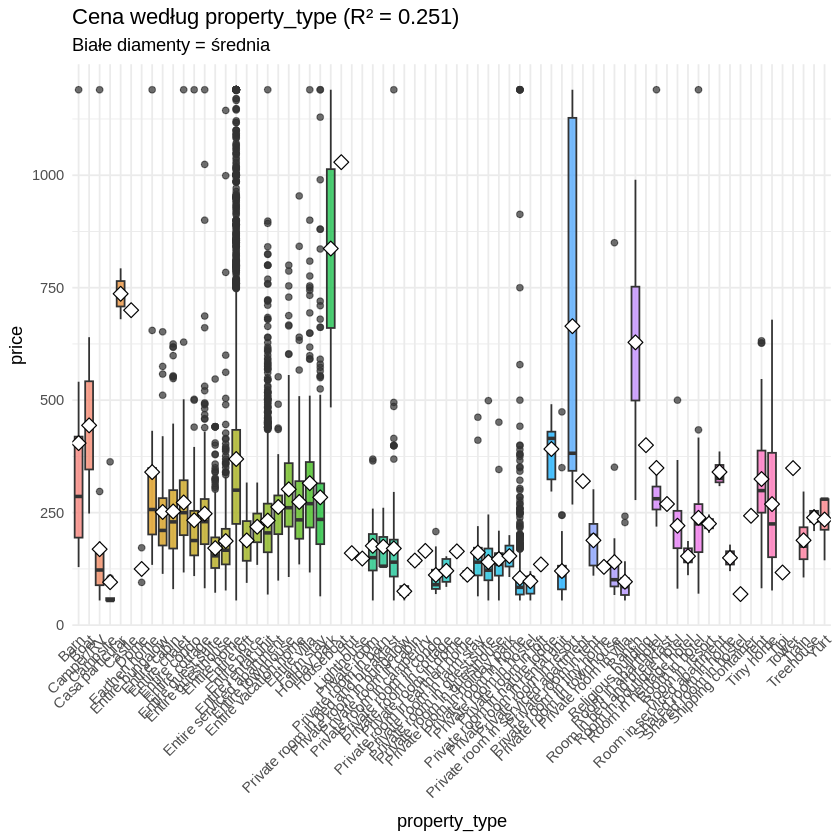

In [37]:
cat("\n--- WSPÓŁCZYNNIK R² DLA ZMIENNYCH KATEGORYCZNYCH ---\n")

# Funkcja do obliczania R²
calc_r2 <- function(num_var, cat_var, data) {
  formula <- as.formula(paste(num_var, "~", cat_var))
  model <- lm(formula, data = data)
  summary(model)$r.squared
}

# Analiza dla ceny
cat_vars <- c("room_type", "property_type", "neighbourhood_cleansed",
             "host_is_superhost", "instant_bookable")

r2_results <- data.frame()
for(cat_var in cat_vars) {
  if(cat_var %in% names(df_clean)) {
    r2 <- calc_r2("price", cat_var, df_clean)
    r2_results <- rbind(r2_results,
                       data.frame(
                         Zmienna_kategoryczna = cat_var,
                         R2_dla_ceny = round(r2, 4)
                       ))
  }
}

r2_results <- r2_results %>% arrange(desc(R2_dla_ceny))
print(r2_results)

# Wizualizacja najsilniejszej zależności
strongest_cat <- r2_results$Zmienna_kategoryczna[1]

p_cat <- ggplot(df_clean, aes_string(x = strongest_cat, y = "price")) +
  geom_boxplot(aes_string(fill = strongest_cat), alpha = 0.7) +
  stat_summary(fun = mean, geom = "point", shape = 23, size = 3, fill = "white") +
  labs(title = sprintf("Cena według %s (R² = %.3f)",
                      strongest_cat, r2_results$R2_dla_ceny[1]),
       subtitle = "Białe diamenty = średnia") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none")

print(p_cat)


--- WYKRESY PAR ZMIENNYCH ---


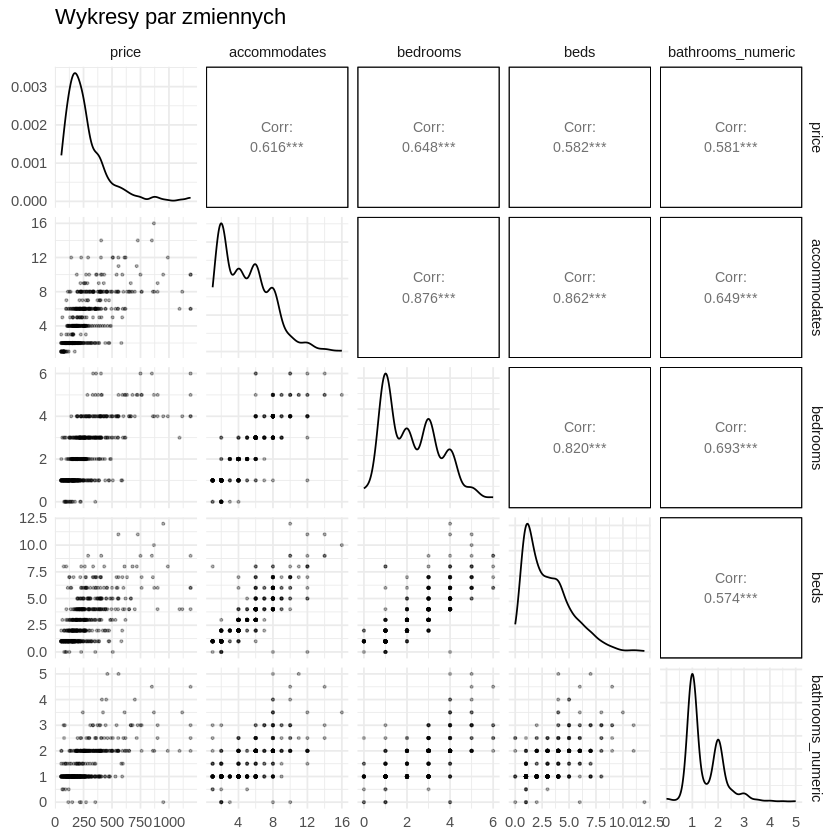

In [38]:
cat("\n--- WYKRESY PAR ZMIENNYCH ---\n")

# Wybór kluczowych zmiennych
pair_vars <- c("price", "accommodates", "bedrooms", "beds", "bathrooms_numeric")
pair_vars <- pair_vars[pair_vars %in% names(df_clean)]

# Próbka dla szybkości
set.seed(123)
sample_size <- min(500, nrow(df_clean))  # Dostosowane do małego zbioru
pair_sample <- df_clean[sample(nrow(df_clean), sample_size), pair_vars]

# Pairplot
pairplot <- ggpairs(
  pair_sample,
  title = "Wykresy par zmiennych",
  upper = list(continuous = wrap("cor", size = 3)),
  lower = list(continuous = wrap("points", alpha = 0.3, size = 0.5)),
  diag = list(continuous = wrap("densityDiag", alpha = 0.5))
)

print(pairplot)

In [39]:
cat("\n=== PODSUMOWANIE ANALIZY ===\n")

# Zapisanie oczyszczonych danych
output_file <- "airbnb_winnipeg_cleaned.csv"
write_csv(df_clean, output_file)
cat(sprintf("\nOczyszczone dane zapisano jako: %s\n", output_file))

# W Google Colab - pobierz plik
cat("\nAby pobrać plik w Google Colab, użyj:\n")
cat("files.download('airbnb_winnipeg_cleaned.csv')\n")

# Przykład kodu do pobrania (odkomentuj i uruchom):
# library(R.utils)
# files.download('airbnb_winnipeg_cleaned.csv')

# Alternatywnie - zapisz na Google Drive
cat("\nAby zapisać na Google Drive:\n")
cat("# library(googledrive)\n")
cat("# drive_auth()\n")
cat("# drive_upload('airbnb_winnipeg_cleaned.csv')\n")

# Całkowity czas analizy
total_time <- difftime(Sys.time(), start_time, units = "mins")
cat(sprintf("\nCałkowity czas analizy: %.1f minut\n", total_time))

cat("\nKLUCZOWE WNIOSKI:\n")
cat("1. Zbiór danych jest stosunkowo mały -", n_before, "obserwacji\n")
cat("2. Po czyszczeniu pozostało", nrow(df_clean), "obserwacji\n")
cat("3. Imputacja MICE skutecznie uzupełniła braki danych\n")
cat("4. Najsilniejsze korelacje z ceną wykazują:",
    paste(top_correlations[1:3], collapse = ", "), "\n")
cat("5. Typ pokoju ma największy wpływ na cenę spośród zmiennych kategorycznych\n")
cat("6. Rozkład cen jest silnie prawostronnie skośny\n")

cat("\nREKOMENDACJE:\n")
cat("- Dla modelowania: Dane są gotowe do budowy modeli predykcyjnych\n")
cat("- Kluczowe predyktory: accommodates, room_type, neighbourhood_cleansed\n")
cat("- Transformacje: Rozważyć logarytmiczną transformację ceny\n")
cat("- Mały zbiór: Rozważyć cross-validation przy budowie modeli\n")

cat("\n=== KONIEC ANALIZY ===\n")

# Informacje o sesji R
cat("\nInformacje o sesji:\n")
cat("R version:", R.version.string, "\n")
cat("Platform:", R.version$platform, "\n")


=== PODSUMOWANIE ANALIZY ===

Oczyszczone dane zapisano jako: airbnb_winnipeg_cleaned.csv

Aby pobrać plik w Google Colab, użyj:
files.download('airbnb_winnipeg_cleaned.csv')

Aby zapisać na Google Drive:
# library(googledrive)
# drive_auth()
# drive_upload('airbnb_winnipeg_cleaned.csv')

Całkowity czas analizy: 5.9 minut

KLUCZOWE WNIOSKI:
1. Zbiór danych jest stosunkowo mały - 12232 obserwacji
2. Po czyszczeniu pozostało 10582 obserwacji
3. Imputacja MICE skutecznie uzupełniła braki danych
4. Najsilniejsze korelacje z ceną wykazują: accommodates, bedrooms, bathrooms_numeric 
5. Typ pokoju ma największy wpływ na cenę spośród zmiennych kategorycznych
6. Rozkład cen jest silnie prawostronnie skośny

REKOMENDACJE:
- Dla modelowania: Dane są gotowe do budowy modeli predykcyjnych
- Kluczowe predyktory: accommodates, room_type, neighbourhood_cleansed
- Transformacje: Rozważyć logarytmiczną transformację ceny
- Mały zbiór: Rozważyć cross-validation przy budowie modeli

=== KONIEC ANALIZY ==